In [1]:
import numpy as np
import tensorflow as tf
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils
from keras import backend as K

np.random.seed(1)

Using TensorFlow backend.


In [2]:
def check_units(y_true, y_pred):
    if y_pred.shape[1] != 1:
        y_pred = y_pred[:,1:2]
        y_true = y_true[:,1:2]
    return y_true, y_pred

def precision(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    y_true, y_pred = check_units(y_true, y_pred)
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def matthews_correlation(y_true, y_pred):
    y_true, y_pred = check_units(y_true, y_pred)
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [4]:
x_train = np.load("datasets/std/x_train_std_200.npy")
y_train = np.load("datasets/std/y_train_std_200.npy")
x_train.shape, y_train.shape

((22046, 200, 200, 3), (22046, 2))

In [5]:
x_val = np.load("datasets/std/x_val_std_200.npy")
y_val = np.load("datasets/std/y_val_std_200.npy")
x_val.shape, y_val.shape

((2756, 200, 200, 3), (2756, 2))

In [6]:
x_test = np.load("datasets/std/x_test_std_200.npy")
y_test = np.load("datasets/std/y_test_std_200.npy")
x_test.shape, y_test.shape

((2756, 200, 200, 3), (2756, 2))

In [7]:
img = x_train[50]
img.shape

(200, 200, 3)

In [8]:
img[50:100, 60:80]

array([[[0.83447025, 0.3045966 , 0.430757  ],
        [0.83447025, 0.3045966 , 0.430757  ],
        [0.83447025, 0.3045966 , 0.430757  ],
        ...,
        [0.87231837, 0.3676768 , 0.46860511],
        [0.88493441, 0.38029284, 0.48122115],
        [0.88493441, 0.38029284, 0.48122115]],

       [[0.83447025, 0.3045966 , 0.430757  ],
        [0.83447025, 0.3045966 , 0.430757  ],
        [0.83447025, 0.3045966 , 0.430757  ],
        ...,
        [0.88493441, 0.38029284, 0.48122115],
        [0.88493441, 0.38029284, 0.48122115],
        [0.88493441, 0.38029284, 0.48122115]],

       [[0.83447025, 0.3045966 , 0.430757  ],
        [0.83447025, 0.3045966 , 0.430757  ],
        [0.83447025, 0.3045966 , 0.430757  ],
        ...,
        [0.88493441, 0.38029284, 0.46860511],
        [0.88493441, 0.38029284, 0.48122115],
        [0.88493441, 0.38029284, 0.48122115]],

       ...,

       [[0.94801461, 0.430757  , 0.48122115],
        [0.97324668, 0.45598908, 0.50645323],
        [0.98586272, 0

In [9]:
print(x_train.shape, y_train.shape)
print(x_val.shape, x_test.shape, y_val.shape, y_test.shape)

(22046, 200, 200, 3) (22046, 2)
(2756, 200, 200, 3) (2756, 200, 200, 3) (2756, 2) (2756, 2)


In [10]:
IMAGE_SIZE = x_train.shape[1]
IMAGE_SIZE

200

In [11]:
def get_model_exp2_b():
    base_model = VGG16(weights='imagenet',include_top=False,pooling='avg',input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    base_model.trainable = False
    X = base_model.output
    X.trainable = False
    
    X = Dense(1024, activation='relu')(X)
    X = Dropout(0.5)(X)
    predictions = Dense(2, activation='softmax', trainable=True)(X)
    
    for layer in base_model.layers[-4:]:
        layer.trainable=False
    
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy', precision, recall, f1, matthews_correlation, auc])
    return model

model = None
model=get_model_exp2_b()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [13]:
# check input
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(22046, 200, 200, 3) (22046, 2) (2756, 200, 200, 3) (2756, 2) (2756, 200, 200, 3) (2756, 2)


In [14]:
model=get_model_exp2_b()
path_model='vgg_exp3_std.h5'  

# set the learning rate
K.set_value(model.optimizer.lr, 0.01) 

h=model.fit(x=x_train,     
            y=y_train, 
            batch_size=64, 
            epochs=50, 
            verbose=1, 
            validation_data=(x_val,y_val),
            shuffle=True,
            )

Train on 22046 samples, validate on 2756 samples
Epoch 1/50
22046/22046 [==============================] - 351s 16ms/step - loss: 0.2060 - acc: 0.9200 - precision: 0.9326 - recall: 0.9096 - f1: 0.9191 - matthews_correlation: 0.8415 - auc: 0.9094 - val_loss: 0.1309 - val_acc: 0.9557 - val_precision: 0.9615 - val_recall: 0.9481 - val_f1: 0.9540 - val_matthews_correlation: 0.9114 - val_auc: 0.9744
Epoch 2/50
22046/22046 [==============================] - 341s 15ms/step - loss: 0.1297 - acc: 0.9584 - precision: 0.9691 - recall: 0.9472 - f1: 0.9573 - matthews_correlation: 0.9170 - auc: 0.9794 - val_loss: 0.1303 - val_acc: 0.9575 - val_precision: 0.9815 - val_recall: 0.9328 - val_f1: 0.9558 - val_matthews_correlation: 0.9162 - val_auc: 0.9820
Epoch 3/50
22046/22046 [==============================] - 341s 15ms/step - loss: 0.1155 - acc: 0.9604 - precision: 0.9713 - recall: 0.9489 - f1: 0.9593 - matthews_correlation: 0.9210 - auc: 0.9837 - val_loss: 0.1132 - val_acc: 0.9612 - val_precision: 0.

22046/22046 [==============================] - 339s 15ms/step - loss: 0.0393 - acc: 0.9855 - precision: 0.9915 - recall: 0.9795 - f1: 0.9852 - matthews_correlation: 0.9711 - auc: 0.9950 - val_loss: 0.1097 - val_acc: 0.9681 - val_precision: 0.9643 - val_recall: 0.9710 - val_f1: 0.9671 - val_matthews_correlation: 0.9362 - val_auc: 0.9950
Epoch 25/50
22046/22046 [==============================] - 338s 15ms/step - loss: 0.0378 - acc: 0.9873 - precision: 0.9928 - recall: 0.9822 - f1: 0.9872 - matthews_correlation: 0.9749 - auc: 0.9951 - val_loss: 0.1030 - val_acc: 0.9677 - val_precision: 0.9827 - val_recall: 0.9522 - val_f1: 0.9666 - val_matthews_correlation: 0.9361 - val_auc: 0.9952
Epoch 26/50
22046/22046 [==============================] - 339s 15ms/step - loss: 0.0347 - acc: 0.9882 - precision: 0.9936 - recall: 0.9830 - f1: 0.9880 - matthews_correlation: 0.9765 - auc: 0.9953 - val_loss: 0.1019 - val_acc: 0.9677 - val_precision: 0.9784 - val_recall: 0.9564 - val_f1: 0.9666 - val_matthews_

22046/22046 [==============================] - 339s 15ms/step - loss: 0.0068 - acc: 0.9980 - precision: 0.9992 - recall: 0.9968 - f1: 0.9980 - matthews_correlation: 0.9959 - auc: 0.9971 - val_loss: 0.1791 - val_acc: 0.9673 - val_precision: 0.9708 - val_recall: 0.9638 - val_f1: 0.9667 - val_matthews_correlation: 0.9348 - val_auc: 0.9972
Epoch 48/50
22046/22046 [==============================] - 339s 15ms/step - loss: 0.0060 - acc: 0.9983 - precision: 0.9989 - recall: 0.9978 - f1: 0.9983 - matthews_correlation: 0.9966 - auc: 0.9972 - val_loss: 0.1838 - val_acc: 0.9673 - val_precision: 0.9671 - val_recall: 0.9675 - val_f1: 0.9667 - val_matthews_correlation: 0.9348 - val_auc: 0.9972
Epoch 49/50
22046/22046 [==============================] - 339s 15ms/step - loss: 0.0046 - acc: 0.9988 - precision: 0.9994 - recall: 0.9981 - f1: 0.9987 - matthews_correlation: 0.9976 - auc: 0.9972 - val_loss: 0.1874 - val_acc: 0.9681 - val_precision: 0.9688 - val_recall: 0.9675 - val_f1: 0.9675 - val_matthews_

In [15]:
model.save(path_model)

In [16]:
 def plot_loss_accu(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Loss')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid(True)
    plt.savefig('exp_3_loss.jpg', dpi=300)
    plt.show()
    
def plot_loss(history):
    loss = history.history['acc']
    val_loss = history.history['val_acc']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Accuracy')
    plt.legend(['train', 'val'], loc='lower right')
    plt.grid(True)
    plt.savefig('exp_3_acc.jpg', dpi=300)
    plt.show()

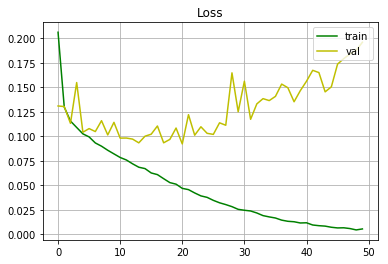

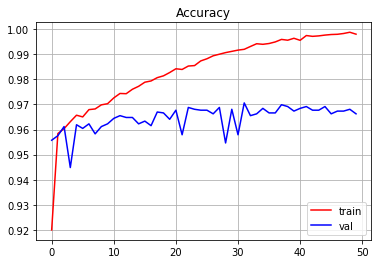

Done!


In [17]:
plot_loss_accu(model.history)
plot_loss(model.history)
print("Done!")

In [18]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2756/2756 [==============================] - 18s 6ms/step
Test loss: 0.14545018536878923
Test accuracy: 0.9702467343976778


In [19]:
y_pred = model.predict(x_test)
# get labels from predictions
pred_labels = np.array([np.argmax(pred) for pred in y_pred])

#convert ground truths to column values
y_test = np.argmax(y_test, axis=1)
accuracy = np.mean((y_test==pred_labels))


In [20]:
accuracy

0.9702467343976778

In [21]:
np.save("y_pred_vgg_exp3_std.npy", y_pred)